In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
from stDCL import *
from utils import clustering
import argparse

In [5]:
parser = argparse.ArgumentParser(description='stDCL', formatter_class=argparse.ArgumentDefaultsHelpFormatter)

# setting
parser.add_argument('--cuda', type=bool, default=True)
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--dataset', type=str, default="151508")
parser.add_argument('--datatype', type=str, default="10x")
parser.add_argument('--n_clusters', type=int, default=7)
parser.add_argument('--prelr', type=float, default=0.001)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--pre_epochs', type=int, default=500)
parser.add_argument('--epochs', type=int, default=1000)
parser.add_argument('--noise', type=int, default=2)
parser.add_argument('--lambda1', type=float, default=10.0)
parser.add_argument('--lambda2', type=float, default=0.5)
parser.add_argument('--lambda3', type=float, default=0.8)
parser.add_argument('--input', type=int, default=3000)
parser.add_argument('--latent_dim', type=int, default=64)
parser.add_argument('--n_neighbors', type=int, default=3, help='parameter k in spatial graph')
parser.add_argument('--n_neighbors_gene', type=int, default=1, help='parameter k in spatial graph')#15
parser.add_argument('--clustertype', type=str, default="mclust")
parser.add_argument('--preprocess', type=bool, default=True)
parser.add_argument('--radius', type=int, default=50)
args, unknown = parser.parse_known_args()

In [7]:
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = './lib/R'
os.environ['R_USER'] = './lib/python3.8/site-packages/rpy2'

file_fold = './DLPFC/' + args.dataset 
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
adata = train(adata, args)

df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

clustering(adata, args, refinement=True)

  0%|          | 0/500 [00:00<?, ?it/s]

Begin to train


100%|██████████| 1000/1000 [00:24<00:00, 40.92it/s]


Optimization finished


  2%|▏         | 9/500 [00:00<00:06, 77.06it/s]

Begin to train


100%|██████████| 1000/1000 [00:24<00:00, 40.27it/s]


Optimization finished


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [8]:
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = np.round(metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth']), 2)
HS = np.round(metrics.homogeneity_score(adata.obs['domain'], adata.obs['ground_truth']), 2)

print('ARI:', ARI)
print('NMI:', NMI)
print('HS:', HS)

ARI: 0.56
NMI: 0.66
HS: 0.67


/home/yuzhuohan/miniconda2/envs/stDCL_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/yuzhuohan/miniconda2/envs/stDCL_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


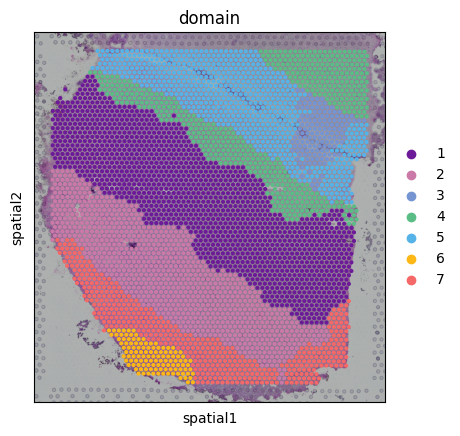

In [9]:
plot_color=["#6D1A98","#CB79A6","#7494D2","#59BD85","#56B3E8","#FDB815",
            "#F46867"]
sc.pl.spatial(adata,
           img_key="hires",
           size=1.2,
           palette=plot_color,
           color=["domain"],
           show=True)